In [20]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as sqlF
from pyspark import SparkContext, SparkConf

In [21]:
from pyspark.ml.clustering import LDA, KMeans, BisectingKMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, NGram
from pyspark.ml import Pipeline

from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, CountVectorizer

from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

In [23]:
conf = SparkConf().setAll([('spark.executor.memory', '5g'), ('spark.driver.memory','5g'),
                          ('spark.driver.maxResultSize','0')])

my_spark = SparkSession \
    .builder.master('local[*]') \
    .appName("ClusterApp")\
    .config(conf=conf)\
    .getOrCreate()

sqlContext = SQLContext(sparkContext=my_spark.sparkContext, 
                        sparkSession=my_spark)

In [24]:
schema = StructType([StructField("product", StringType(), True),
                 StructField("votes", IntegerType(), True),
                 StructField("rate", DoubleType(), True),
                 StructField("original_text", StringType(), True),
                 StructField("text", StringType(), True),
                 StructField("summary", StringType(), True)])

csv_reader = sqlContext.read.\
                options(header='false', 
                inferschema='false',
                delimiter="\t").\
                schema(schema)

In [25]:
#for i in range(17):
#    print("Reading file:",i)
#    if i<10:
#        file = "hdfs://localhost:9000/TextMining/tokens/part-0000"+str(i)
#    else:
#        file = "hdfs://localhost:9000/TextMining/tokens/part-000"+str(i)
#    df = csv_reader.csv(file)
#    if i == 0:
#        df1 = df
#    else:
#        df1 = df1.union(df)

df = csv_reader.csv("hdfs://localhost:9000/TextMining/tokens/part-*").na.drop()

In [7]:
df.count()

5464515

In [26]:
df.show(5)

+----------+-----+----+--------------------+--------------------+--------------------+
|   product|votes|rate|       original_text|                text|             summary|
+----------+-----+----+--------------------+--------------------+--------------------+
|0143065971|    4| 5.0|This is a masterp...|masterpiec someon...|Fantastic Book Ab...|
|0143065971|    1| 5.0|Great condition a...| great condit great |          Five Stars|
|1423600150|    1| 5.0|Excellent book on...|excel sauc fun tr...|           excellent|
|1423600150|    1| 5.0|          Great book|              great |          Five Stars|
|1423600150|    1| 5.0|   Great mexi stuff.|   great mexi stuff |          Five Stars|
+----------+-----+----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [10]:
df.select("summary","rate","votes").groupBy("summary").agg(sqlF.mean("rate"), sqlF.stddev("rate"),sqlF.mean("votes"), sqlF.count("summary")).orderBy(sqlF.desc("count(summary)")).show(50)

+-------------+------------------+--------------------+------------------+--------------+
|      summary|         avg(rate)|   stddev_samp(rate)|        avg(votes)|count(summary)|
+-------------+------------------+--------------------+------------------+--------------+
|   Five Stars| 4.999690033584435| 0.02595899673204438|1.0748753735948426|        351651|
|   Four Stars| 4.000785180180592|0.036501725483390694| 1.047421230906883|        109529|
|  Three Stars|3.0014877317641835| 0.06160290302887173| 1.068813145331409|         45035|
|     One Star| 1.010877745091332| 0.19630745112776773|1.4211192447150578|         29234|
|    Good read|  4.33580830239622|  0.6443431345569475|1.1683260209247384|         23704|
|   Great read| 4.786770428015564| 0.43685592471735185|1.2047608148317692|         21845|
|   Great book| 4.838728492271799|  0.4096785813256267|1.2277631962671334|         20574|
|    Two Stars|2.0020052444855776| 0.07687121197439592| 1.189521312149725|         19449|
|    Loved

In [11]:
summary_res = df.select("summary","rate","votes").groupBy("summary").agg(sqlF.mean("rate"),sqlF.mean("votes"), sqlF.count("summary")).orderBy(sqlF.desc("count(summary)")).toPandas()

In [13]:
summary_res[summary_res["count(summary)"]>10000][["summary","count(summary)"]]

,summary,count(summary)
0,Five Stars,351651
1,Four Stars,109529
2,Three Stars,45035
3,One Star,29234
4,Good read,23704
5,Great read,21845
6,Great book,20574
7,Two Stars,19449
8,Loved it!,16543
9,Loved it,15746


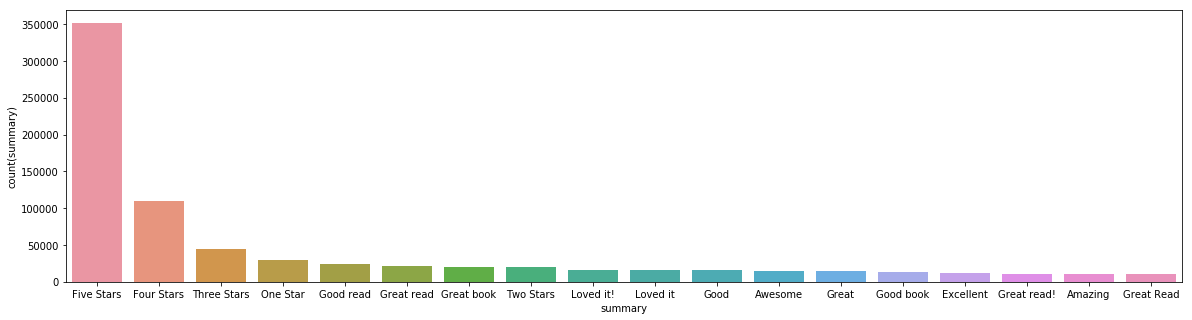

In [15]:
plt.figure(figsize=(20,5))
sns.barplot(x="summary", y="count(summary)", data=summary_res[summary_res["count(summary)"]>10000][["summary","count(summary)"]])
plt.show()

In [16]:
df.createTempView('data')

In [17]:
sqlContext.sql("SELECT * FROM data WHERE votes>1 ORDER BY votes DESC").show()

+----------+-----+----+--------------------+--------------------+--------------------+
|   product|votes|rate|       original_text|                text|             summary|
+----------+-----+----+--------------------+--------------------+--------------------+
|B00C2WDD5I|  991| 4.0|"The Atlantis Gen...|money atlanti gen...|An exciting new v...|
|B000GFK7L6|  986| 4.0|Update November 1...|updat novemb orig...|Very good electro...|
|B00C2WDD5I|  970| 1.0|I'll be honest, t...|honest onli thing...|Lacks restraint a...|
|B003ICWE92|  908| 1.0|The Anne of Green...|ann green gabl se...|What is up with t...|
|B00SRY5F8I|  904| 5.0|I do not remember...|not rememb buy ap...|I do not remember...|
|B00EOARZ4G|  842| 5.0|First - to all re...|first reader revi...|     As it should be|
|B006PJ3UKC|  798| 5.0|I have nothing bu...|noth good thing s...|            Love it!|
|B00DMCV7K0|  797| 1.0|As soon as I star...|soon start read n...|Amazon needs to l...|
|B00D01TYQ2|  784| 1.0|This book is in n...

# Preprocessing and optimal k and n finder

In [16]:
def get_pipeline(n, k):
    tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
    ngram = NGram(inputCol="words", outputCol="n-gram").setN(n)
    tf = CountVectorizer(inputCol="n-gram", outputCol="tf")
    idf = IDF(inputCol="tf", outputCol="features", minDocFreq=3)
    clus = KMeans().setSeed(123).setK(k)


    pipeline = Pipeline(stages=[tokenizer, ngram, tf,idf, clus])
    return pipeline

In [17]:
all_res = dict()
for n in range(1,4):
    k_mean_res = []
    for k in range(2,8):
        start_ = time.time()
        evaluator = ClusteringEvaluator()
        pipeline = get_pipeline(n,k)
        model = pipeline.fit(df)
        df2 = model.transform(df)
        silhouette = evaluator.evaluate(df2)
        k_mean_res.append(silhouette)
        print("For n=", n, "and k=", k, "Silhouette = " + str(silhouette),
             "and took", str(round(time.time()-start_)), "s")
    all_res[n] = k_mean_res

For n= 1 and k= 2 Silhouette = 0.7818085663836597 and took 1158 s
For n= 1 and k= 3 Silhouette = 0.6267032164405654 and took 1143 s
For n= 1 and k= 4 Silhouette = 0.6266415172733281 and took 1154 s
For n= 1 and k= 5 Silhouette = 0.5795984101983523 and took 1159 s
For n= 1 and k= 6 Silhouette = 0.6238906185754778 and took 1179 s
For n= 1 and k= 7 Silhouette = 0.5672296785087502 and took 1176 s
For n= 2 and k= 2 Silhouette = 0.6367249295540462 and took 1010 s
For n= 2 and k= 3 Silhouette = 0.44214115115171454 and took 1012 s
For n= 2 and k= 4 Silhouette = 0.10317123265485793 and took 1017 s
For n= 2 and k= 5 Silhouette = 0.10319041989166616 and took 1026 s
For n= 2 and k= 6 Silhouette = 0.10564232146660846 and took 1035 s
For n= 2 and k= 7 Silhouette = 0.10631923033061005 and took 1051 s
For n= 3 and k= 2 Silhouette = 0.06653576342243957 and took 5091 s
For n= 3 and k= 3 Silhouette = 0.06806348935246632 and took 5046 s
For n= 3 and k= 4 Silhouette = 0.0678879417657483 and took 5085 s
For

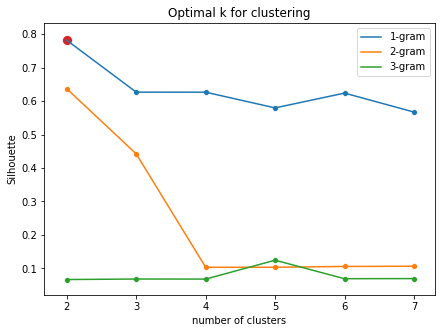

In [25]:
plt.figure(figsize=(7,5))
sns.lineplot(list(range(2,8)),all_res[1])
sns.scatterplot(list(range(2,8)),all_res[1])

sns.lineplot(list(range(2,8)),all_res[2])
sns.scatterplot(list(range(2,8)),all_res[2])

sns.lineplot(list(range(2,8)),all_res[3])
sns.scatterplot(list(range(2,8)),all_res[3])

sns.scatterplot(list(range(2,3)), all_res[1][0], s=100)

plt.xlabel('number of clusters')
plt.ylabel('Silhouette')
plt.title('Optimal k for clustering')
plt.xticks(list(range(2,8)))
plt.legend(["1-gram","2-gram","3-gram"])
plt.show()

In [30]:
#2 is the best
evaluator = ClusteringEvaluator()
clus = get_pipeline(1,2)#KMeans().setSeed(123).setK(2)
cluster_model = clus.fit(df)

In [32]:
df2 = cluster_model.transform(df)

In [34]:
df2.select('product','votes','rate','text','prediction').show()

+----------+-----+----+--------------------+----------+
|   product|votes|rate|                text|prediction|
+----------+-----+----+--------------------+----------+
|0143065971|    4| 5.0|masterpiec someon...|         0|
|0143065971|    1| 5.0| great condit great |         0|
|1423600150|    1| 5.0|excel sauc fun tr...|         0|
|1423600150|    1| 5.0|              great |         0|
|1423600150|    1| 5.0|   great mexi stuff |         0|
|1423600150|    1| 5.0|go favorit chef c...|         0|
|1423600150|    1| 5.0| uniqu delici salsa |         0|
|1423600150|    1| 5.0|  excel right topic |         0|
|1423600150|    1| 5.0|great littl cookb...|         0|
|1423600150|    1| 3.0|rather disappoint...|         0|
|1423600150|    1| 4.0|mailman seem eith...|         0|
|1423600150|    1| 1.0|no color photo no...|         0|
|1423600150|    1| 5.0|veri good read hi...|         0|
|1423600150|    4| 5.0|great littl simpl...|         0|
|1423600150|    1| 5.0|good pic recip ea...|    

In [36]:
df2.select('product','votes','rate','text','prediction').write.mode('overwrite').options(header='true').csv('hdfs://localhost:9000/TextMining/tokens/clustered')

In [39]:
df2.select("prediction").groupBy("prediction").count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|         1| 396681|
|         0|5067834|
+----------+-------+



In [42]:
assembler = VectorAssembler(inputCols=['votes','rate','prediction'], outputCol="corr_features")
corr_df = assembler.transform(df2)
pearsonCorr = Correlation.corr(corr_df, 'corr_features', 'pearson').collect()

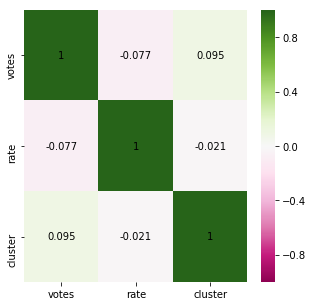

In [43]:
plt.figure(figsize=(5, 5))
sns.heatmap(pearsonCorr[0][0].values.reshape(3,3), 
            vmax=1, vmin=-1, annot=True,annot_kws={'color':'black'},
            xticklabels=['votes','rate','cluster'], 
            yticklabels=['votes','rate','cluster'], 
            center=0, cmap="PiYG")
plt.show()

In [45]:
df2.select(['rate','prediction']).groupBy('prediction').mean().show()

+----------+-----------------+---------------+
|prediction|        avg(rate)|avg(prediction)|
+----------+-----------------+---------------+
|         1|4.219705506439683|            1.0|
|         0|4.306976905715539|            0.0|
+----------+-----------------+---------------+



In [7]:
schema = StructType([StructField("product", StringType(), True),
                 StructField("votes", IntegerType(), True),
                 StructField("rate", DoubleType(), True),
                 StructField("text", StringType(), True),
                 StructField("cluster", IntegerType(), True)])

clus_df = sqlContext.read.\
                options(header='true', 
                inferschema='false',
                delimiter=",").\
                schema(schema).csv("hdfs://localhost:9000/TextMining/tokens/clustered/*")

In [8]:
text_0 = clus_df.filter("cluster==0").select("text")
text_1 = clus_df.filter("cluster==1").select("text")

In [9]:
res_0 = text_0.rdd.flatMap(lambda x: x[0].split(" ")).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)
res_1 = text_1.rdd.flatMap(lambda x: x[0].split(" ")).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)

In [10]:
schema = StructType([StructField("words", StringType(), True),
                 StructField("count", IntegerType(), True)])
res_df_0 = sqlContext.createDataFrame(res_0, schema=schema)
res_df_1 = sqlContext.createDataFrame(res_1, schema=schema)

In [11]:
res_df_0.groupBy().sum("count").show()

+----------+
|sum(count)|
+----------+
| 121834908|
+----------+



In [18]:
res_df_0.groupBy('words').agg(sqlF.mean("count")/121834908).orderBy(sqlF.desc("(avg(count) / 121834908)")).show()

+-------+------------------------+
|  words|(avg(count) / 121834908)|
+-------+------------------------+
|    not|     0.02615862770627282|
|  stori|     0.01842476049639238|
|   love|     0.01573012227333073|
|    one|    0.009538218718070523|
|  great|    0.009476701045319459|
|   like|    0.009369096416931674|
|   good|    0.009223653700300738|
|charact|     0.00883133592549682|
|   veri|    0.008295184168399422|
|   seri|    0.007996033452087476|
|  enjoy|    0.007584640684425189|
|   read|    0.006733694090366...|
| realli|    0.006405052647144445|
|    get|    0.006207925236008715|
|   well|    0.005909660965148...|
|   time|    0.005519895824930...|
|    end|     0.00512440982842126|
|  money|    0.005116325117592735|
|   want|    0.005027311220196432|
|   make|    0.004270623325787713|
+-------+------------------------+
only showing top 20 rows



In [57]:
res_df_1.groupBy().sum("count").show()

+----------+
|sum(count)|
+----------+
|  71093558|
+----------+



In [19]:
res_df_1.groupBy('words').agg(sqlF.mean("count")/71093558).orderBy(sqlF.desc("(avg(count) / 71093558)")).show()

+-------+-----------------------+
|  words|(avg(count) / 71093558)|
+-------+-----------------------+
|    not|   0.022785172743780807|
|  stori|   0.011111527151306732|
|   love|   0.009325992658856658|
|    one|   0.008907276802773045|
|   like|   0.007594640290756...|
|charact|   0.006481839043700696|
|    get|    0.00616903995717868|
|  money|   0.006132637221504655|
|   time|   0.005525746791291554|
|   want|   0.005159201625553...|
| realli|   0.004617985218857...|
|   make|   0.004448743443111963|
|   know|   0.004353362086618312|
|   life|   0.004224503716637729|
|  first|   0.004103184707677733|
|   veri|   0.004074996499682854|
|    way|   0.004067485270606375|
|     go|   0.003976323705728724|
|   seri|   0.003877285196501...|
|   well|   0.003827674513069...|
+-------+-----------------------+
only showing top 20 rows



In [51]:
word_cloud_0 = res_df_0.toPandas().set_index('words').T.to_dict('records')
word_cloud_1 = res_df_1.toPandas().set_index('words').T.to_dict('records')

In [52]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

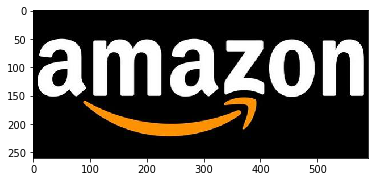

In [53]:
mask = np.array(Image.open("amazon.jpg"))

plt.imshow(mask, cmap="gray")
plt.show()

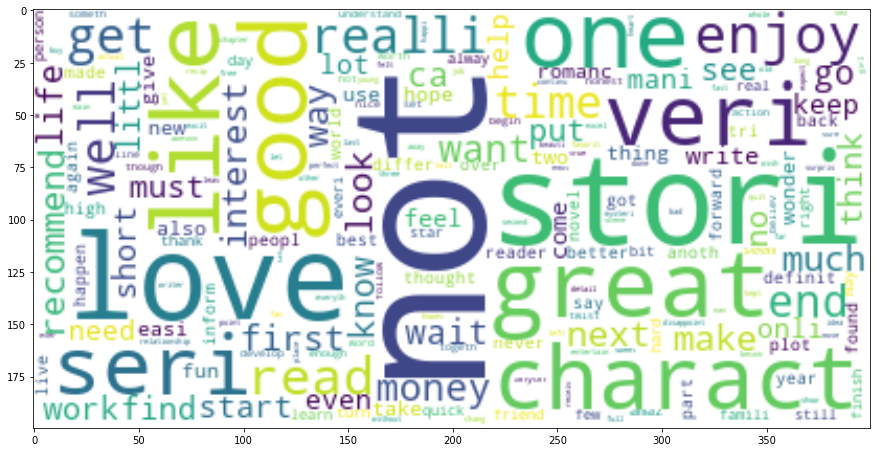

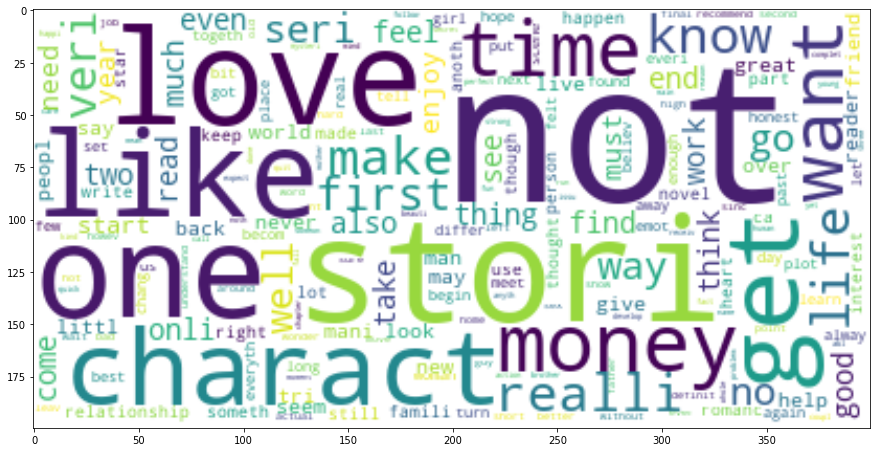

In [55]:
wc_0 = WordCloud(background_color="white", max_words=200)#, 
               #mask=mask, contour_color="black", contour_width=0)
wc_0.generate_from_frequencies(dict(*word_cloud_0))

wc_1 = WordCloud(background_color="white", max_words=200)#, 
               #mask=mask, contour_color="black", contour_width=0)
wc_1.generate_from_frequencies(dict(*word_cloud_1))

plt.figure(figsize=(15,10))
plt.imshow(wc_0, interpolation='bilinear')
plt.show()

plt.figure(figsize=(15,10))
plt.imshow(wc_1, interpolation='bilinear')
plt.show()

# LDA

In [27]:
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
ngram = NGram(n=1, inputCol="words", outputCol="n-gram")
tf = CountVectorizer(inputCol="n-gram", outputCol="tf")
idf = IDF(inputCol="tf", outputCol="features", minDocFreq=30)

pipeline = Pipeline(stages=[tokenizer, ngram, tf,idf])

pipe_mod = pipeline.fit(df)

df2 = pipe_mod.transform(df)

In [29]:
lda = LDA(k=10, maxIter=10)

In [30]:
model = lda.fit(df2)

In [31]:
vocab = pipe_mod.stages[-2].vocabulary

# Next, let's grab the topics generated by our LDA model via describeTopics(). Using collect(),
# we load the output into a Python array.
raw_topics = model.describeTopics().collect()

# Lastly, let's get the indices of the vocabulary terms from our topics
topic_inds = [ind.termIndices for ind in raw_topics]

# The indices we just grab directly map to the term at position <ind> from our vocabulary. 
# Using the below code, we can generate the mappings from our topic indices to our vocabulary.
topics = []
for topic in topic_inds:
    _topic = []
    for ind in topic:
        _topic.append(vocab[ind])
    topics.append(_topic)

# Let's see our topics!
for i, topic in enumerate(topics, start=1):
    print(f"topic {i}: {topic}")

topic 1: ['money', 'inform', 'not', 'good', 'veri', 'use', 'recip', 'like', 'help', 'great']
topic 2: ['love', 'not', 'stori', 'one', 'seri', 'get', 'want', 'make', 'life', 'find']
topic 3: ['not', 'god', 'money', 'stori', 'life', 'use', 'word', 'one', 'veri', 'great']
topic 4: ['money', 'life', 'not', 'world', 'war', 'histori', 'one', 'stori', 'time', 'year']
topic 5: ['stori', 'recip', 'love', 'not', 'good', 'great', 'veri', 'one', 'like', 'laugh']
topic 6: ['not', 'like', 'diet', 'one', 'stori', 'eat', 'get', 'realli', 'weight', 'good']
topic 7: ['charact', 'stori', 'not', 'seri', 'like', 'enjoy', 'love', 'end', 'one', 'romanc']
topic 8: ['great', 'not', 'money', 'stori', 'love', 'one', 'no', 'riley', 'get', 'good']
topic 9: ['stori', 'not', 'charact', 'money', 'like', 'novel', 'love', 'time', 'one', 'well']
topic 10: ['love', 'not', 'stori', 'get', 'wait', 'one', 'ca', 'want', 'seri', 'like']


In [14]:
#k=20

vocab = pipe_mod.stages[-2].vocabulary

# Next, let's grab the topics generated by our LDA model via describeTopics(). Using collect(),
# we load the output into a Python array.
raw_topics = model.describeTopics().collect()

# Lastly, let's get the indices of the vocabulary terms from our topics
topic_inds = [ind.termIndices for ind in raw_topics]

# The indices we just grab directly map to the term at position <ind> from our vocabulary. 
# Using the below code, we can generate the mappings from our topic indices to our vocabulary.
topics = []
for topic in topic_inds:
    _topic = []
    for ind in topic:
        _topic.append(vocab[ind])
    topics.append(_topic)

# Let's see our topics!
for i, topic in enumerate(topics, start=1):
    print(f"topic {i}: {topic}")

topic 1: ['chloe', 'brad', 'not', 'billi', 'gon', 'stori', 'na', 'great', 'one', 'interest']
topic 2: ['chris', 'quinn', 'stephani', 'riley', 'maddi', 'finn', 'eden', 'stori', 'love', 'not']
topic 3: ['stori', 'not', 'charact', 'enjoy', 'seri', 'good', 'end', 'love', 'veri', 'short']
topic 4: ['ok', 'jane', 'austen', 'stori', 'victoria', 'love', 'not', 'great', 'ha', 'tucker']
topic 5: ['love', 'not', 'stori', 'life', 'one', 'get', 'feel', 'want', 'heart', 'like']
topic 6: ['love', 'matt', 'not', 'stori', 'get', 'one', 'like', 'nathan', 'shade', 'grey']
topic 7: ['bear', 'seri', 'love', 'not', 'zombi', 'one', 'game', 'stori', 'find', 'like']
topic 8: ['not', 'fairi', 'stori', 'like', 'love', 'vampir', 'one', 'get', 'know', 'natali']
topic 9: ['love', 'not', 'want', 'seri', 'stori', 'one', 'get', 'wait', 'ca', 'see']
topic 10: ['seri', 'forward', 'enjoy', 'charact', 'love', 'look', 'entertain', 'read', 'stori', 'great']
topic 11: ['stori', 'christian', 'world', 'life', 'reader', 'well',

# Sentiment with TextBlob

In [17]:
df = csv_reader.csv("hdfs://localhost:9000/TextMining/cleaned_data/part-*").na.drop()

In [18]:
df.show()

+----------+-----+----+--------------------+
|   product|votes|rate|                text|
+----------+-----+----+--------------------+
|0143065971|    1| 5.0|Great condition a...|
|0143065971|    4| 5.0|This is a masterp...|
|1423600150|    1| 5.0|Great little cook...|
|1423600150|    1| 5.0|   Great mexi stuff.|
|1423600150|    1| 5.0|          Great book|
|1423600150|    1| 5.0|Excellent book on...|
|1423600150|    1| 3.0|It is rather disa...|
|1423600150|    1| 5.0|Some unique and d...|
|1423600150|    1| 5.0|Excellent book ri...|
|1423600150|    1| 5.0|Going to a favori...|
|1423600150|   16| 5.0|Many people are s...|
|1423600150|    4| 3.0|I admire the SF S...|
|1423600150|    1| 5.0|This book has goo...|
|1423600150|    1| 4.0|If you like makin...|
|1423600150|    4| 5.0|great little book...|
|1423600150|    1| 4.0|The Mailman seeme...|
|1423600150|    1| 5.0|I usually make up...|
|1423600150|    1| 1.0|No color photos. ...|
|1423600150|    1| 5.0|VERY GOOD READING...|
|142360015

In [21]:
df.printSchema()

<bound method DataFrame.printSchema of DataFrame[product: string, votes: int, rate: double, text: string]>

In [19]:
from textblob import TextBlob

def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_udf = sqlF.udf(sentiment_analysis , FloatType())

In [24]:
df = df.withColumn("sentiment_score", sentiment_udf(df['text']))

In [26]:
df.show()

+----------+-----+----+--------------------+---------------+
|   product|votes|rate|                text|sentiment_score|
+----------+-----+----+--------------------+---------------+
|0143065971|    1| 5.0|Great condition a...|            0.9|
|0143065971|    4| 5.0|This is a masterp...|     0.11708705|
|1423600150|    1| 5.0|Great little cook...|       0.340625|
|1423600150|    1| 5.0|   Great mexi stuff.|            0.8|
|1423600150|    1| 5.0|          Great book|            0.8|
|1423600150|    1| 5.0|Excellent book on...|           0.65|
|1423600150|    1| 3.0|It is rather disa...|    0.036666665|
|1423600150|    1| 5.0|Some unique and d...|         0.6875|
|1423600150|    1| 5.0|Excellent book ri...|     0.64285713|
|1423600150|    1| 5.0|Going to a favori...|            0.5|
|1423600150|   16| 5.0|Many people are s...|     0.27673653|
|1423600150|    4| 3.0|I admire the SF S...|          -0.75|
|1423600150|    1| 5.0|This book has goo...|     0.56666666|
|1423600150|    1| 4.0|I

In [28]:
assembler = VectorAssembler(inputCols=['votes','rate','sentiment_score'], outputCol="corr_features")

corr_df = assembler.transform(df)
pearsonCorr = Correlation.corr(corr_df, 'corr_features', 'pearson').collect()

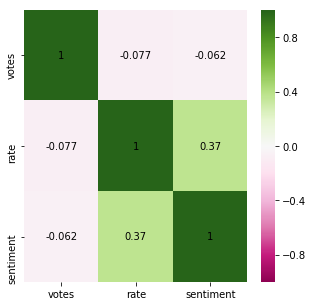

In [29]:
plt.figure(figsize=(5, 5))
sns.heatmap(pearsonCorr[0][0].values.reshape(3,3), 
            vmax=1, vmin=-1, annot=True,annot_kws={'color':'black'},
            xticklabels=['votes','rate','sentiment'], 
            yticklabels=['votes','rate','sentiment'], 
            center=0, cmap="PiYG")
plt.show()

In [35]:
df.select('votes','rate','sentiment_score').groupBy('rate').mean('votes','sentiment_score').show()

+----+------------------+--------------------+
|rate|        avg(votes)|avg(sentiment_score)|
+----+------------------+--------------------+
| 1.0|3.3596850028055645|-0.01607412162580...|
| 4.0|1.4177290404419742|  0.2772317332324222|
| 3.0|1.7377818403412553| 0.18949055701067982|
| 2.0|2.5251020121007457| 0.07714642109464315|
| 5.0|1.5615217834308246| 0.33499123732359426|
+----+------------------+--------------------+



In [32]:
my_spark.stop()